In [1]:
import os
import json
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from matplotlib import cm
plt.style.use('fast')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)
print(f"Using device: {device}")

Using device: cuda


In [2]:
def tau(x, xi):
    """
    Compute τ(x,ξ) = ξ²(1-x)/√[ξ²(1-x)²+1] + 1/[(1-x)√[ξ²(1-x)²+1]] - ξ
    """
    term1 = xi**2 * (1-x) / torch.sqrt(xi**2 * (1-x)**2 + 1)
    term2 = 1 / ((1-x) * torch.sqrt(xi**2 * (1-x)**2 + 1))
    return term1 + term2 - xi

def fourier_series_solution(t, theta):
    """
    Compute Fourier series x̃(t) = α sin(ω t)² + β sin(2 ω t)² + γ sin(3 ω t)²
    """
    omega, alpha, beta, gamma = theta
    return (alpha * torch.sin(omega * t)**2 +
            beta * torch.sin(2 * omega * t)**2 +
            gamma * torch.sin(3 * omega * t)**2)

def fourier_residual(t, theta, k, xi):
    """
    Compute the residual for the generalized equation using automatic differentiation
    """
    # Create tensor that requires gradients
    t_req_grad = t.clone().detach().requires_grad_(True)
    
    # Get x(t) from Fourier series
    x_t = fourier_series_solution(t_req_grad, theta)
    
    # First derivative
    dx_dt = torch.autograd.grad(
        x_t, t_req_grad, 
        grad_outputs=torch.ones_like(x_t),
        create_graph=True
    )[0]
    
    # Second derivative
    d2x_dt2 = torch.autograd.grad(
        dx_dt, t_req_grad,
        grad_outputs=torch.ones_like(dx_dt),
        create_graph=True
    )[0]
    
    # Compute τ(x,ξ)
    tau_val = tau(x_t, xi)
    
    # Residual: τ⁻¹(x,ξ)⋅ẍ + τ⁻¹(x,ξ)⋅x - K = 0
    residual = (d2x_dt2 + x_t) / tau_val - k
    
    return residual

def optimize_theta_for_k_xi(k_val, xi_val, N=100, n_iter=2000, lr=3e-4, print_every=1000):
    """
    Optimize Fourier parameters for given K and ξ values
    """
    t_points = torch.linspace(0, 5 * np.pi, N, device=device)
    
    # Initial guess - use k_val for initialization
    theta = torch.tensor([1.0, k_val, k_val/2, k_val/4], device=device, requires_grad=True)
    
    optimizer = optim.Adam([theta], lr=lr)
    
    best_loss = float('inf')
    best_theta = None
    
    for it in range(n_iter):
        optimizer.zero_grad()
        residuals = fourier_residual(t_points, theta, k_val, xi_val)
        loss = torch.mean(residuals**2)
        loss.backward()
        optimizer.step()
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_theta = theta.detach().clone()
        
        if (it+1) % print_every == 0:
            print(f"[K={k_val:.3f}, ξ={xi_val:.3f}] Iter {it+1:4d}: loss={loss.item():.4e}, theta={theta.data.cpu().numpy()}")
    
    return best_theta, best_loss

def runge_kutta_ode(k, xi, dt=1e-5, T=5*np.pi, epsilon=1e-8):
    """
    Solve x'' = k * tau(x, xi) - x with RK4.
    Initial conditions: x(0)=0, x'(0)=0.
    Returns:
        t (np.ndarray), x (np.ndarray)
    """
    k = float(k)
    xi = float(xi)

    def tau_np(x):
        # τ(x,ξ) = ξ²(1-x)/√[ξ²(1-x)²+1] + 1/[(1-x)√[ξ²(1-x)²+1]] - ξ
        omx = 1.0 - x
        # avoid division by zero near x -> 1
        mask = np.abs(omx) < epsilon
        if np.any(mask):
            s = np.sign(omx)
            s[s == 0.0] = 1.0
            omx = omx.copy()
            omx[mask] = epsilon * s[mask]
        sqrt_term = np.sqrt(xi**2 * omx**2 + 1.0)
        return xi**2 * omx / sqrt_term + 1.0 / (omx * sqrt_term) - xi

    N = int(T / dt) + 1
    t = np.linspace(0.0, T, N)
    x = np.zeros(N, dtype=np.float64)
    v = np.zeros(N, dtype=np.float64)  # x'

    def acc(x_val):
        return k * tau_np(np.array([x_val], dtype=np.float64))[0] - x_val

    for i in range(N - 1):
        k1x = v[i]
        k1v = acc(x[i])

        k2x = v[i] + 0.5 * dt * k1v
        k2v = acc(x[i] + 0.5 * dt * k1x)

        k3x = v[i] + 0.5 * dt * k2v
        k3v = acc(x[i] + 0.5 * dt * k2x)

        k4x = v[i] + dt * k3v
        k4v = acc(x[i] + dt * k3x)

        x[i+1] = x[i] + (dt / 6.0) * (k1x + 2.0*k2x + 2.0*k3x + k4x)
        v[i+1] = v[i] + (dt / 6.0) * (k1v + 2.0*k2v + 2.0*k3v + k4v)

    return t, x

In [ ]:
# Comparison plots for different xi values (4 rows, 2 columns)
xi_comparison_values = [0.1, 0.5, 1.0, 2.0]
k_comparison_values = [0.15, 0.1, 0.05]

fig, axes = plt.subplots(4, 2, figsize=(16, 20), dpi=300)

light_colors = ['#7fbfff', '#ffbf7f', '#7fdf7f']
normal_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

print("\nGenerating comparison plots for different xi values...")

for i, xi_val in enumerate(xi_comparison_values):
    ax_left = axes[i, 0]
    ax_right = axes[i, 1]
    legend_elements = []
    
    for j, k_val in enumerate(k_comparison_values):
        t_rk, x_rk = runge_kutta_ode(k_val, xi_val, dt=1e-5, T=5*np.pi)
        print(f"Optimizing for K={k_val:.3f}, ξ={xi_val:.3f}")
        best_theta, _ = optimize_theta_for_k_xi(k_val, xi_val, n_iter=15000, lr=3e-4, print_every=1000)
        t_fourier = torch.linspace(0, 5 * np.pi, 100, device=device)
        x_fourier = fourier_series_solution(t_fourier, best_theta).detach().cpu().numpy()
        
        # Plot solutions
        fourier_line, = ax_left.plot(t_fourier.cpu().numpy(), x_fourier, '-', linewidth=2, color=light_colors[j])
        rk4_line, = ax_left.plot(t_rk[::100], x_rk[::100], '--', linewidth=2, color=normal_colors[j])
        
        # Plot error
        from scipy.interpolate import interp1d
        t_fourier_np = t_fourier.cpu().numpy()
        f = interp1d(t_rk, x_rk, kind='cubic', bounds_error=False, fill_value='extrapolate')
        x_rk_interp = f(t_fourier_np)
        abs_error = np.abs(x_fourier - x_rk_interp)
        error_line, = ax_right.plot(t_fourier_np, abs_error, '-', linewidth=2, color=normal_colors[j])
        
        legend_elements.append((fourier_line, f'Fourier K={k_val}'))
        legend_elements.append((rk4_line, f'RK4 K={k_val}'))
    
    ax_left.set_title('Solutions', fontsize=14)
    ax_left.set_xlabel('Time (t)', fontsize=14)
    ax_left.set_ylabel('x(t)', fontsize=14)
    ax_left.grid(True, alpha=0.6)
    ax_left.set_xlim(0, 5*np.pi)
    
    ax_right.set_title('Absolute Error', fontsize=14)
    ax_right.set_xlabel('Time (t)', fontsize=14)
    ax_right.set_ylabel('|Fourier - RK4|', fontsize=14)
    ax_right.grid(True, alpha=0.6)
    ax_right.set_xlim(0, 5*np.pi)
    ax_right.set_yscale('log')
    
    handles = [item[0] for item in legend_elements]
    labels = [item[1] for item in legend_elements]
    fig.legend(handles, labels, loc='upper center', 
               bbox_to_anchor=(0.5, 0.92 - 0.23*i), ncol=len(k_comparison_values)*2, 
               fontsize=12, title=f'ξ = {xi_val}', title_fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('figs/comparison_xi_solutions_with_errors.pdf', bbox_inches='tight', dpi=300)

In [3]:
# Load or compute theta for a grid of (K, ξ)
k_star = 0.201  # Pull-in threshold for ξ → 0
k_values = np.linspace(0.01, 0.19, 20)
xi_values = np.linspace(0.1, 2.0, 20)

params_file = 'data/theta_values_k_xi_grid.npz'

os.makedirs('data', exist_ok=True)
os.makedirs('figs', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

if os.path.exists(params_file):
    print("Loading precomputed theta values...")
    data = np.load(params_file)
    all_k = data['all_k']
    all_xi = data['all_xi']
    all_theta = data['all_theta']
    print(f"Loaded data for {len(all_k)} combinations.")
else:
    print("Computing theta values for grid...")
    all_k = []
    all_xi = []
    all_theta = []
    
    for k in k_values:
        for xi in xi_values:
            print(f"\nOptimizing for K={k:.3f}, ξ={xi:.3f}")
            best_theta, loss = optimize_theta_for_k_xi(k, xi, n_iter=20000, lr=1e-3, print_every=1000)
            all_k.append(k)
            all_xi.append(xi)
            all_theta.append(best_theta.cpu().numpy())
            print(f"Optimized: {best_theta.cpu().numpy()} loss: {loss:.4e}")
    
    all_k = np.array(all_k)
    all_xi = np.array(all_xi)
    all_theta = np.array(all_theta)
    np.savez(params_file, all_k=all_k, all_xi=all_xi, all_theta=all_theta)
    print(f"Saved {len(all_k)} combinations to {params_file}")


Loading precomputed theta values...
Loaded data for 400 combinations.


In [4]:
input_tensor = torch.tensor(np.column_stack((all_k, all_xi)), dtype=torch.float64, device=device)
output_tensor = torch.tensor(all_theta, dtype=torch.float64, device=device)

class KXiToThetaNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(2, 64),  # Input: [K, ξ]
            nn.GELU(),
            nn.Linear(64, 128),
            nn.GELU(),
            nn.Linear(128, 64),
            nn.GELU(),
            nn.Linear(64, 32),
            nn.GELU(),
            nn.Linear(32, 4)   # Output: [ω, α, β, γ]
        )
    
    def forward(self, x):
        return self.network(x)

model = KXiToThetaNet().to(device)
model_path = 'saved_models/k_xi_theta_model.pt'

# Check if model exists and load it if it does
if os.path.exists(model_path):
    print(f"Loading saved model from {model_path}...")
    model.load_state_dict(torch.load(model_path))
    print("Model loaded successfully.")
    model.eval()
else:
    print("\nTraining neural network to map (K, ξ) to theta parameters...")
    optimizer = optim.Adam(model.parameters(), lr=3e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200000)
    
    n_epochs = 200000
    patience = 10000
    best_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(1, n_epochs + 1):
        optimizer.zero_grad()
        predictions = model(input_tensor)
        loss = torch.mean((predictions - output_tensor) ** 2)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if loss.item() < best_loss:
            best_loss = loss.item()
            epochs_without_improvement = 0
            # Save best model
            torch.save(model.state_dict(), model_path)
        else:
            epochs_without_improvement += 1
    
        if epoch % 1000 == 0:
            print(f"Epoch {epoch:6d}, Loss: {loss.item():.4e}")
        
        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch} due to lack of improvement.")
            break
    
    print(f"Final loss: {loss.item():.4e}")
    model.eval()

Loading saved model from saved_models/k_xi_theta_model.pt...
Model loaded successfully.


Target ξ = 0.1, closest available ξ = 0.10
Target ξ = 0.5, closest available ξ = 0.50
Target ξ = 1.0, closest available ξ = 1.00
Target ξ = 2.0, closest available ξ = 2.00


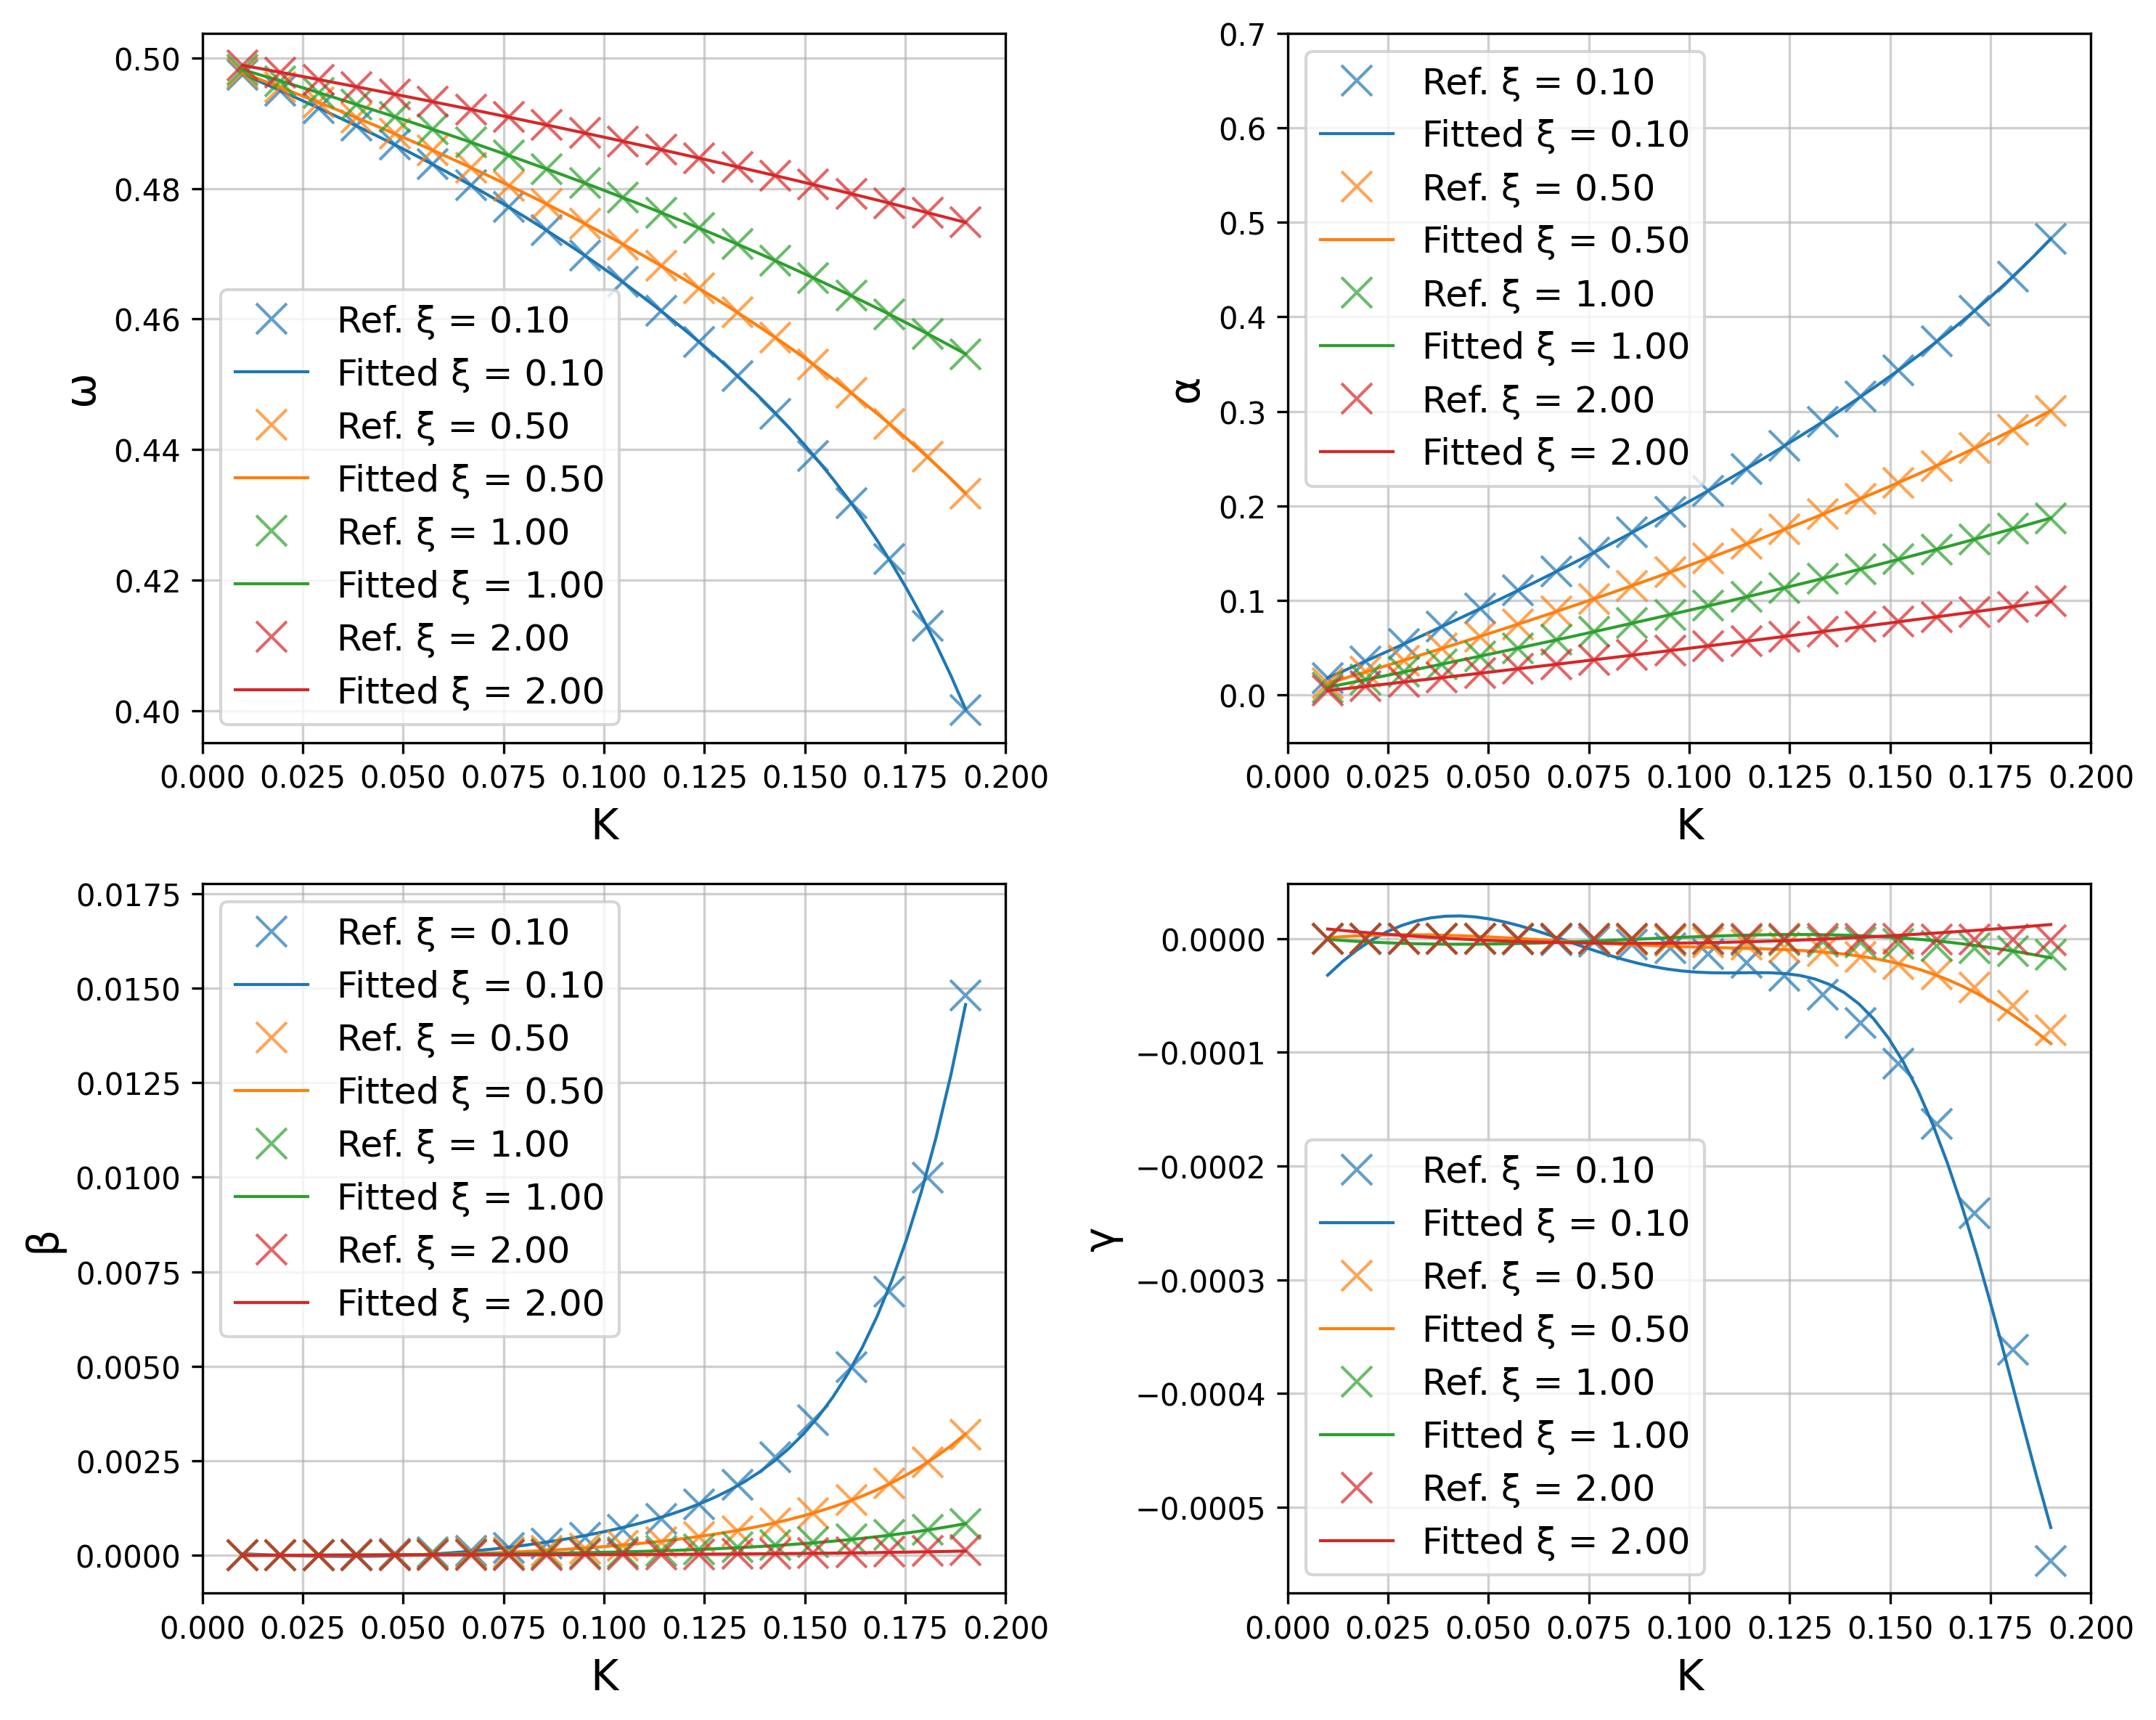

In [8]:
# Plot parameters for selected xi values
xi_target_values = [0.1, 0.5, 1.0, 2.0]
k_plot_values = np.linspace(0.01, 0.19, 50)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
param_labels = ['ω', 'α', 'β', 'γ']

# Find closest xi values in the data
xi_actual_values = []
for xi_target in xi_target_values:
    unique_xi = np.unique(all_xi)
    closest_idx = np.argmin(np.abs(unique_xi - xi_target))
    xi_actual = unique_xi[closest_idx]
    xi_actual_values.append(xi_actual)
    print(f"Target ξ = {xi_target}, closest available ξ = {xi_actual:.2f}")

plt.figure(figsize=(10, 8), dpi=300)

for i, param_name in enumerate(param_labels):
    plt.subplot(2, 2, i + 1)
    plt.grid(True, alpha=0.6)
    max_ref_value = 0
    
    for j, (xi_target, xi_actual) in enumerate(zip(xi_target_values, xi_actual_values)):
        k_xi_pairs = torch.tensor([[k, xi_actual] for k in k_plot_values], dtype=torch.float64, device=device)
        with torch.no_grad():
            predictions = model(k_xi_pairs)
        param_values = predictions[:, i].cpu().numpy()
        matching_indices = np.where(np.abs(all_xi - xi_actual) < 1e-6)[0]
        
        if len(matching_indices) > 0:
            if i == 2:
                max_val = np.max(all_theta[matching_indices, i])
                if max_val > max_ref_value:
                    max_ref_value = max_val
            plt.plot(all_k[matching_indices], all_theta[matching_indices, i], 'x', 
                     alpha=0.7, label=f'Ref. ξ = {xi_actual:.2f}', 
                     markersize=10, color=colors[j])
        plt.plot(k_plot_values, param_values, '-', color=colors[j], label=f'Fitted ξ = {xi_actual:.2f}', linewidth=1)
    
    plt.xlabel('K', fontsize=14)
    plt.ylabel(param_name, fontsize=14)
    plt.xlim(min(k_plot_values) - 0.01, max(k_plot_values) + 0.01)
    if i == 1:
        plt.ylim(-0.05, max(plt.ylim()[1], 0.7))
    elif i == 2:
        plt.ylim(-0.001, max_ref_value * 1.2)
        plt.legend(fontsize=12, loc='upper left')
        continue
    plt.legend(fontsize=12, loc='best')

plt.tight_layout()
plt.savefig('figs/parameters_by_xi.pdf', bbox_inches='tight', dpi=300)
plt.show()


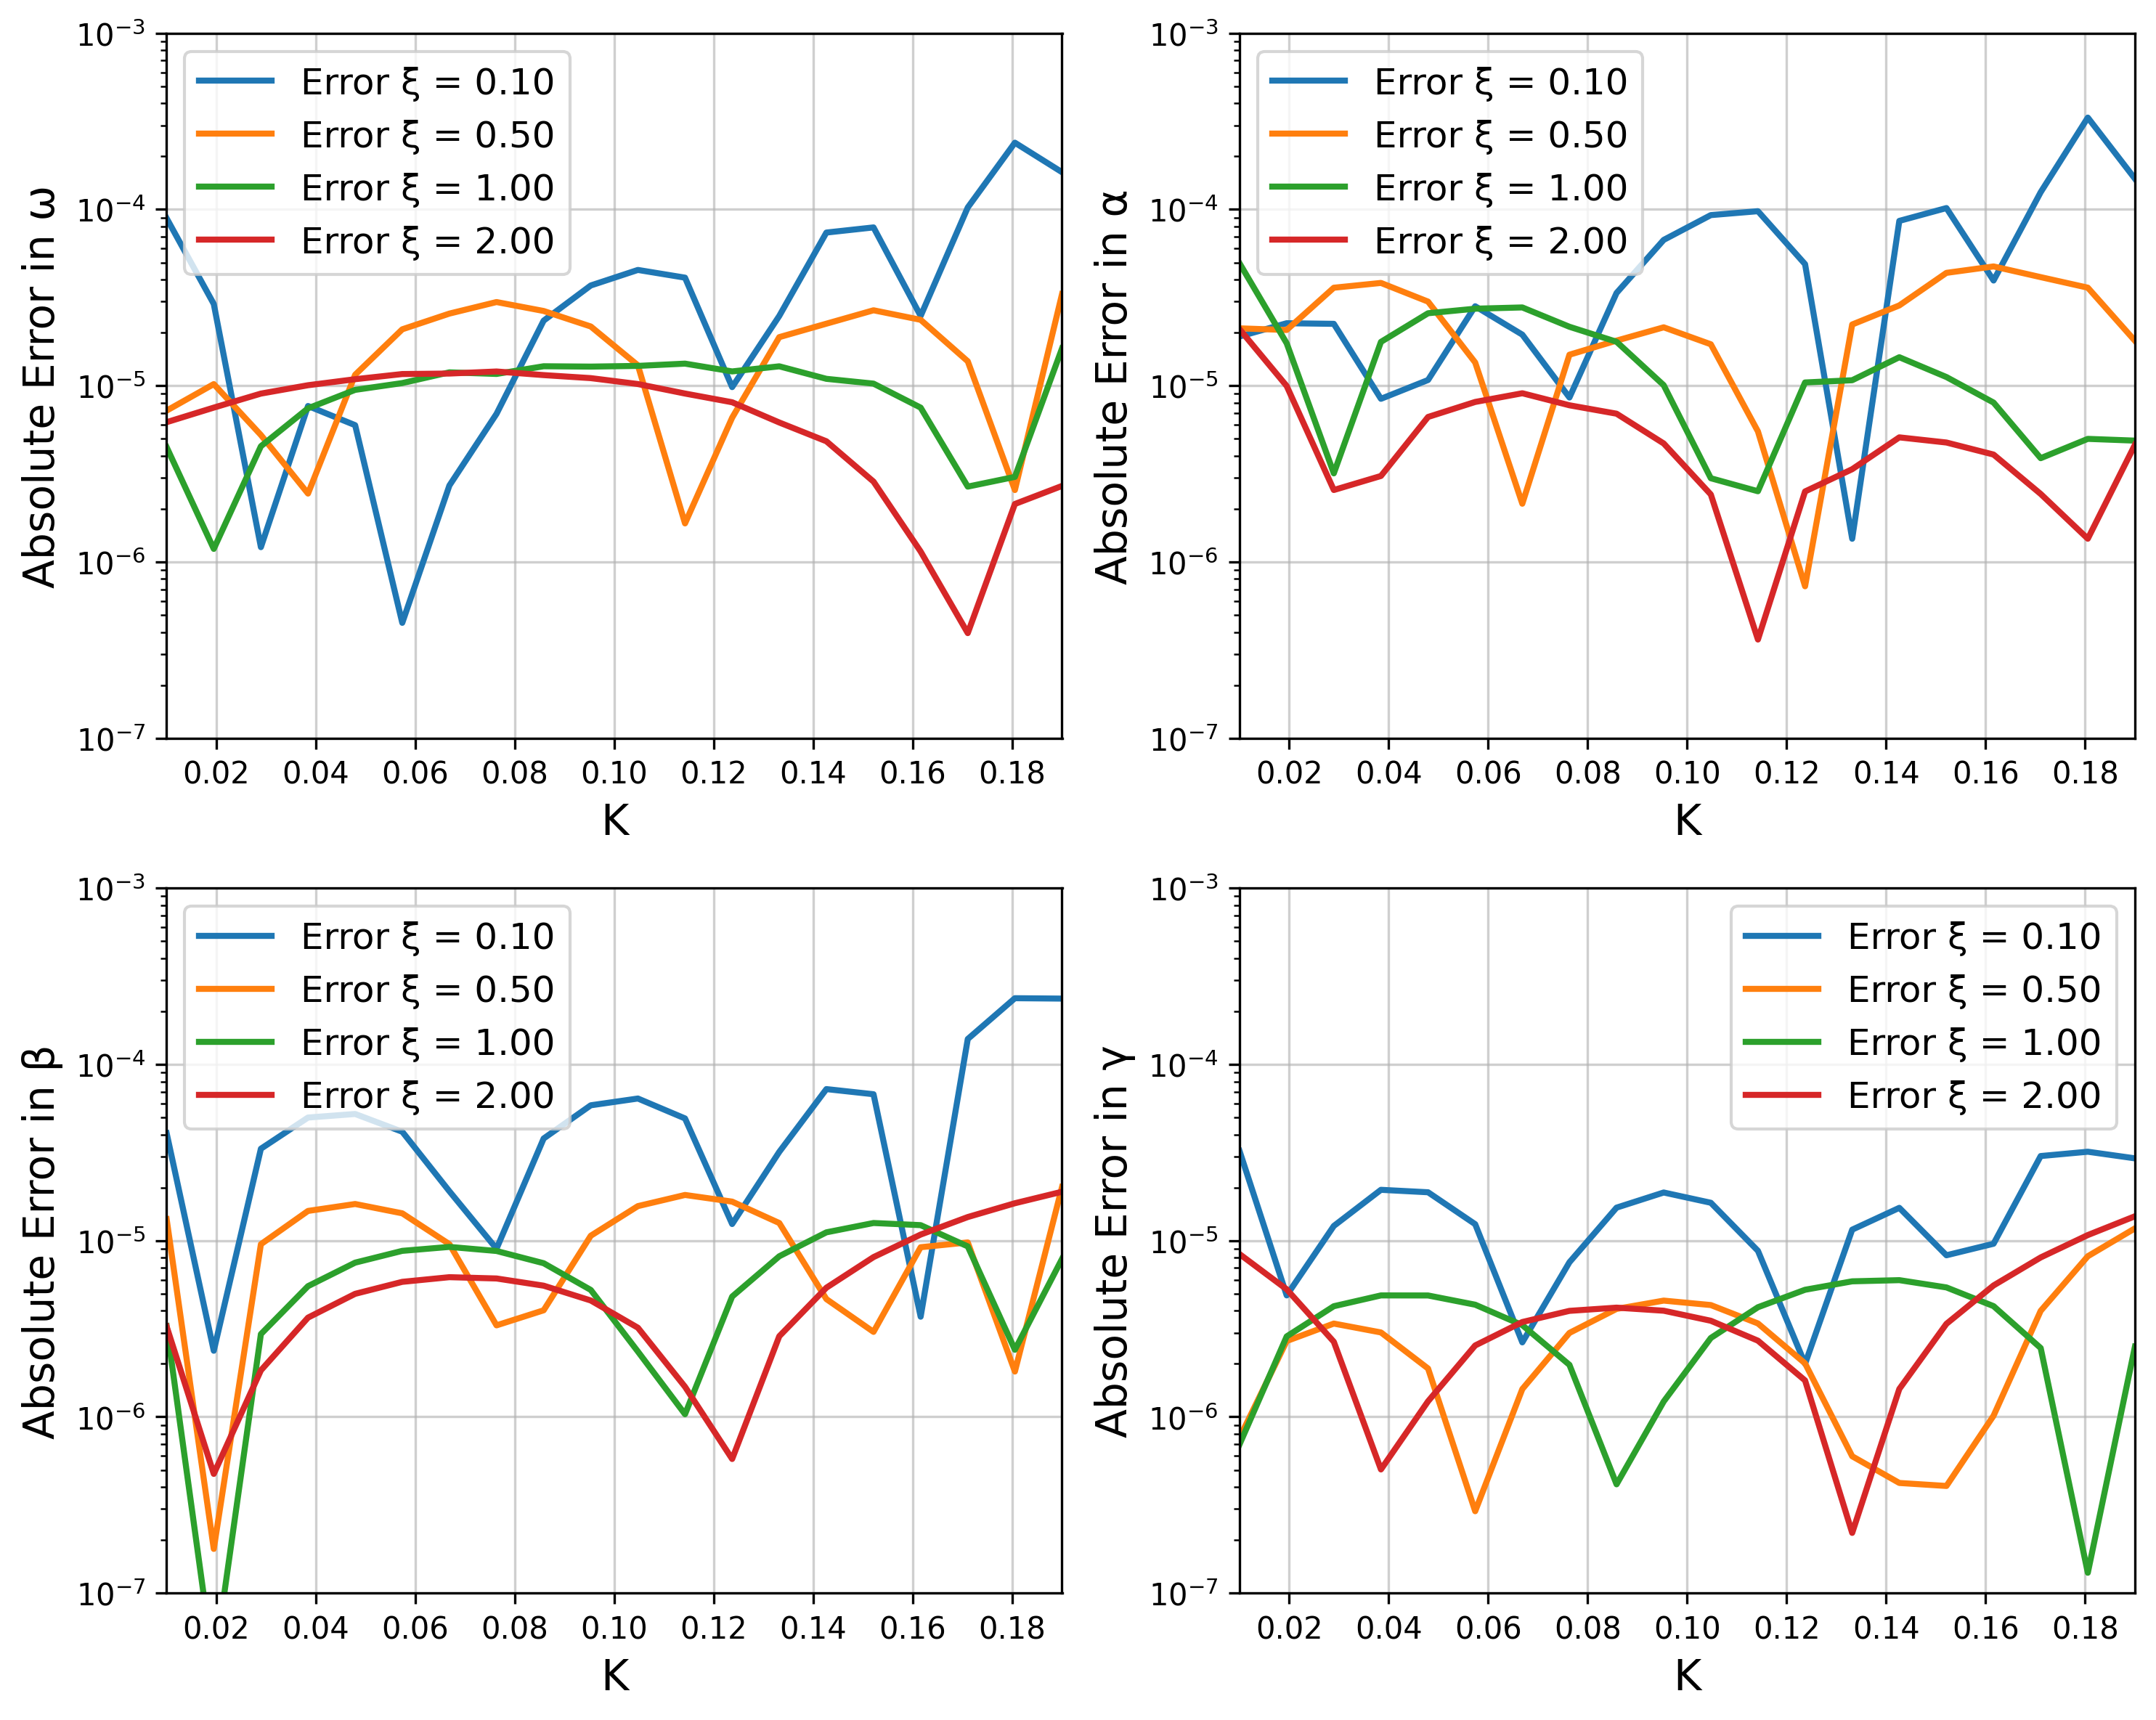

In [9]:
# Plot errors for selected xi values
xi_target_values = [0.1, 0.5, 1.0, 2.0]
k_plot_values = np.linspace(0.01, 0.19, 50)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
param_labels = ['ω', 'α', 'β', 'γ']

model.eval()

plt.figure(figsize=(10, 8), dpi=300)

for i, param_name in enumerate(param_labels):
    plt.subplot(2, 2, i + 1)
    plt.grid(True, alpha=0.6)
    
    for j, (xi_target, xi_actual) in enumerate(zip(xi_target_values, xi_actual_values)):
        # Get reference data for this xi value
        matching_indices = np.where(np.abs(all_xi - xi_actual) < 1e-6)[0]
        
        if len(matching_indices) > 0:
            # Get model predictions for this xi value
            k_xi_pairs = torch.tensor([[k, xi_actual] for k in k_plot_values], 
                                      dtype=torch.float64, device=device)
            
            with torch.no_grad():
                predictions = model(k_xi_pairs)
            
            # Find true values for matching k values
            ref_k_values = all_k[matching_indices]
            ref_theta_values = all_theta[matching_indices, i]
            
            # Interpolate predictions at the reference k values for fair comparison
            pred_values_interp = np.interp(ref_k_values, 
                                          k_plot_values, 
                                          predictions[:, i].cpu().numpy())
            
            # Calculate absolute errors
            abs_errors = np.abs(ref_theta_values - pred_values_interp)
            
            # Plot errors
            plt.plot(ref_k_values, abs_errors, '-', 
                     linewidth=2, color=colors[j], 
                     label=f'Error ξ = {xi_actual:.2f}')
    
    plt.xlabel('K', fontsize=14)
    plt.ylabel(f'Absolute Error in {param_name}', fontsize=14)
    plt.yscale('log')
    plt.legend(fontsize=12, loc='best')
    plt.xlim(min(k_plot_values), max(k_plot_values))
    
    # Set reasonable y-limits for the log scale
    plt.ylim(1e-7, 1e-3)

plt.tight_layout()
plt.savefig('figs/parameter_errors_by_xi.pdf', dpi=300, bbox_inches='tight')
plt.show()

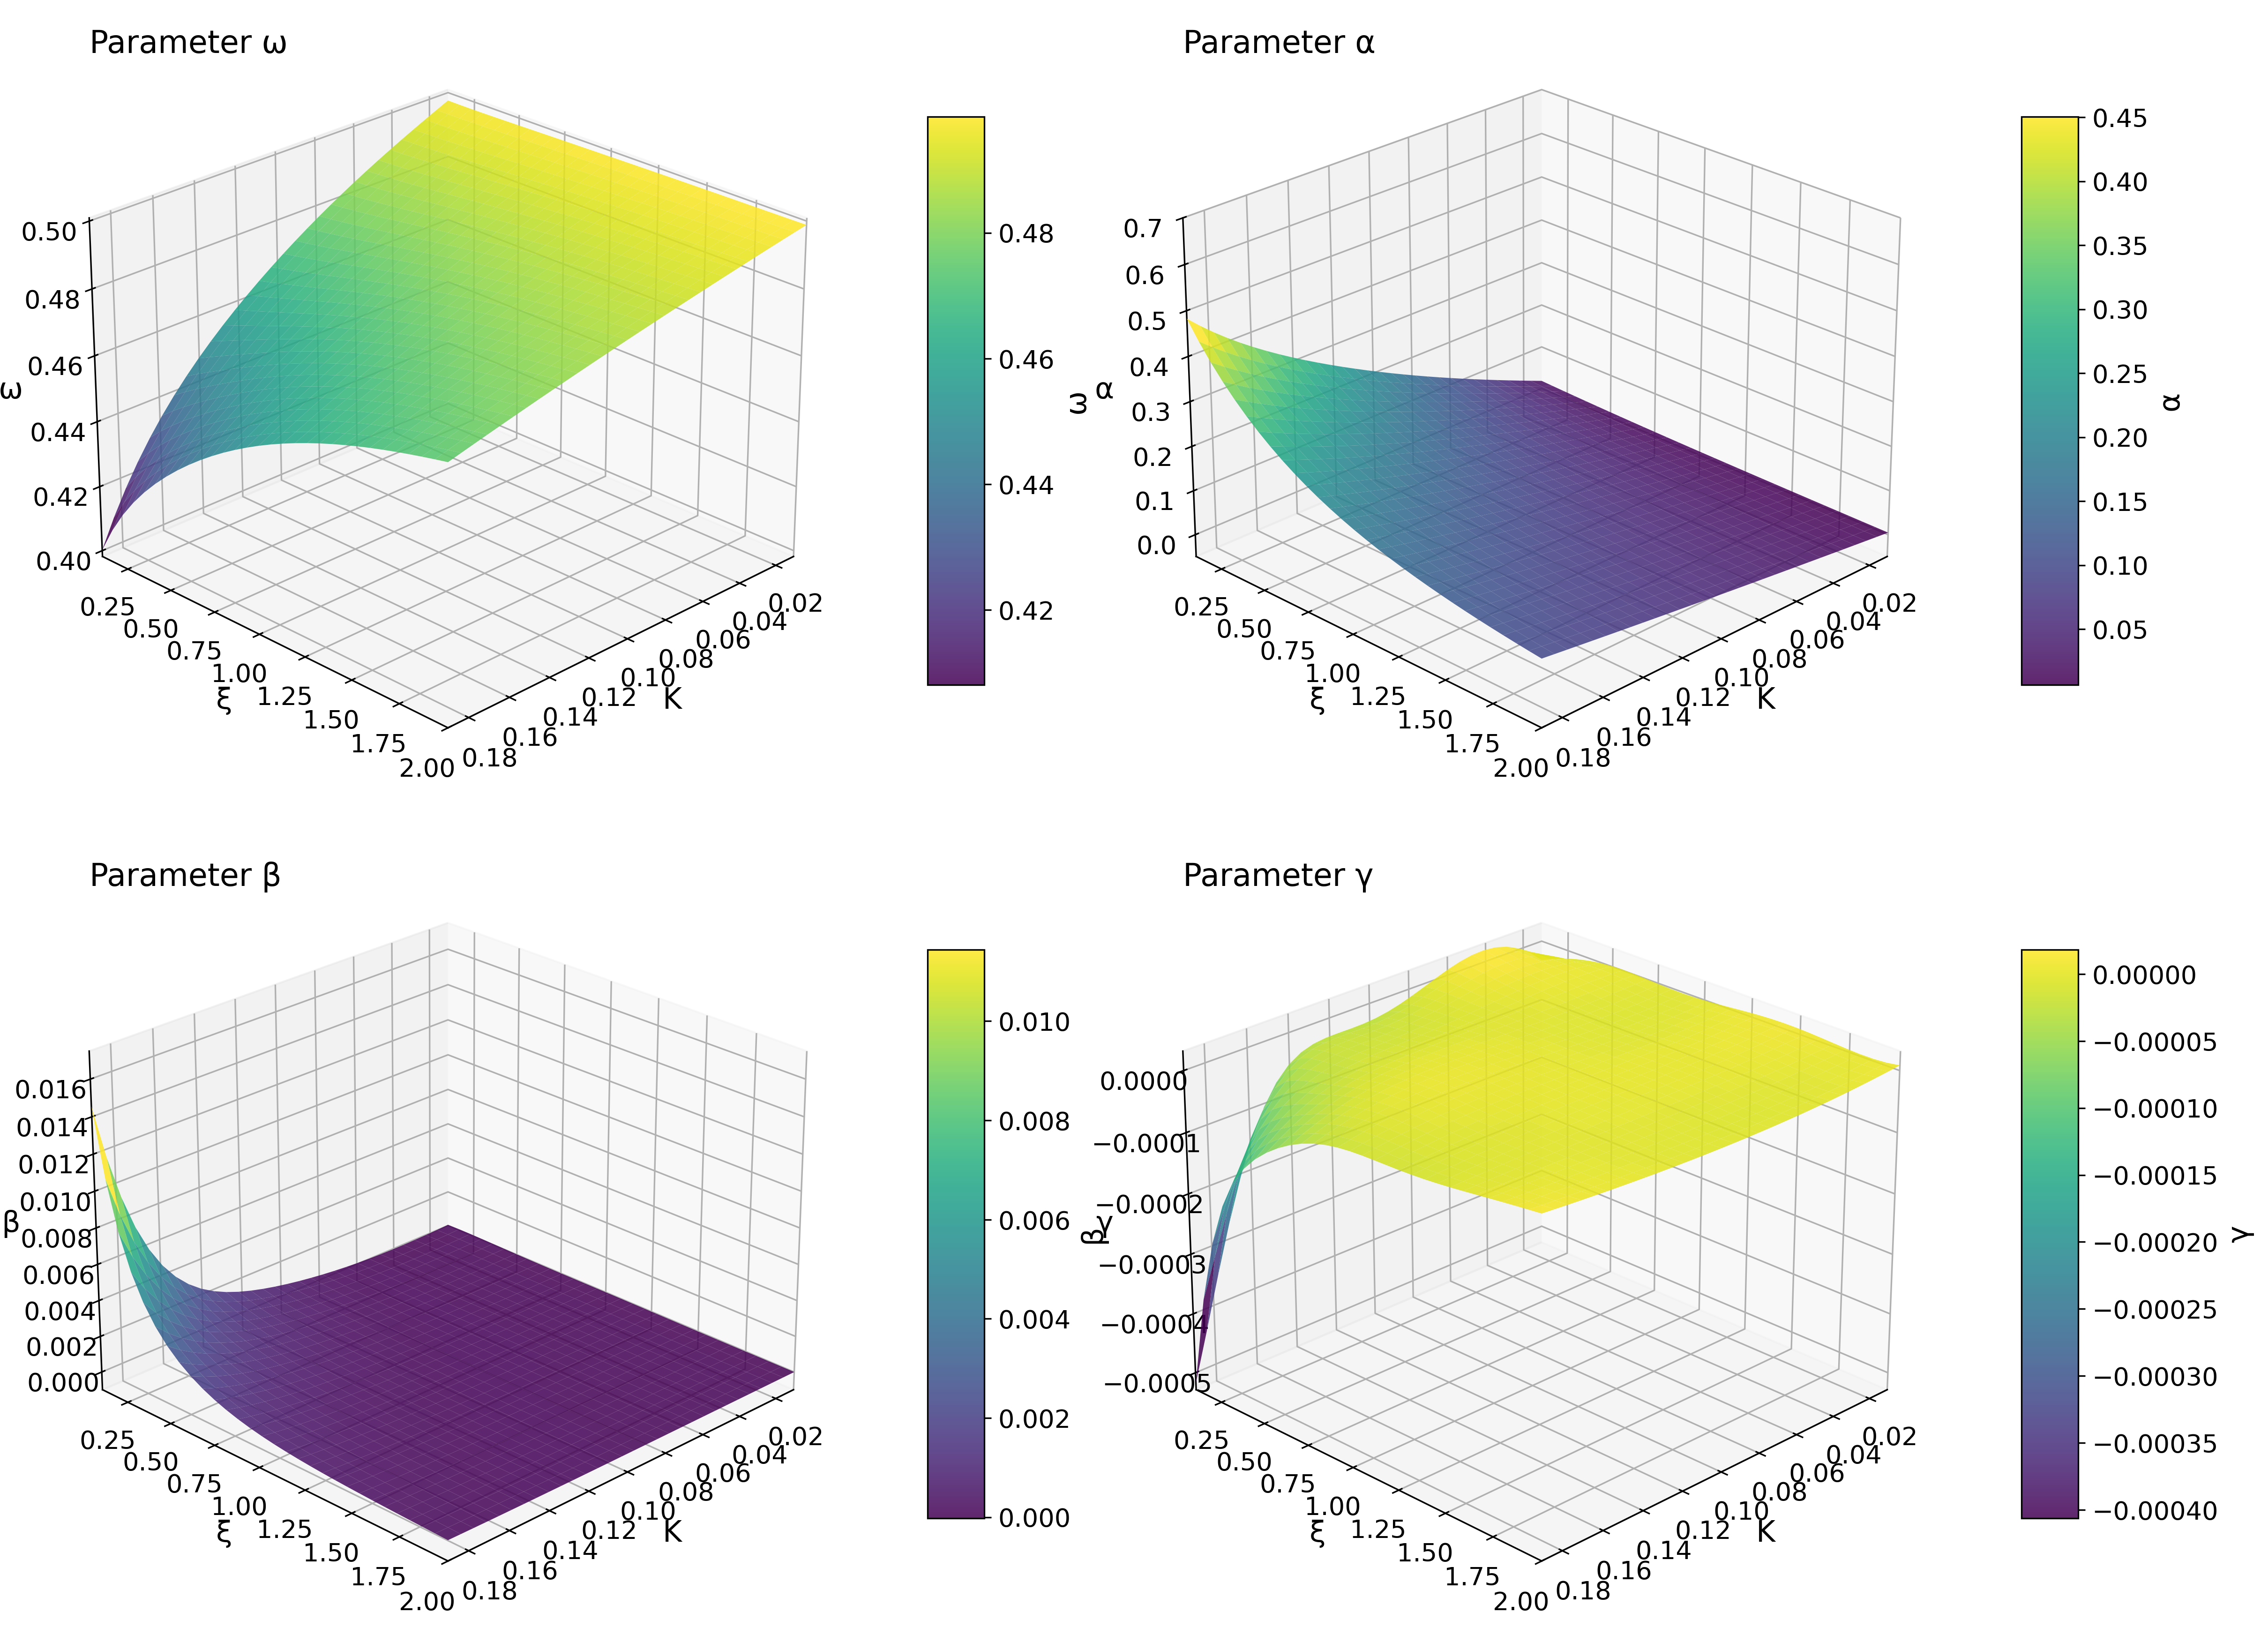

In [6]:
# 3D plots for each parameter
fig = plt.figure(figsize=(16, 12), dpi=300)

k_grid = np.linspace(0.01, 0.19, 30)
xi_grid = np.linspace(0.1, 2.0, 30)
K_grid, XI_grid = np.meshgrid(k_grid, xi_grid)
grid_points = np.column_stack((K_grid.flatten(), XI_grid.flatten()))

with torch.no_grad():
    grid_input = torch.tensor(grid_points, dtype=torch.float64, device=device)
    grid_output = model(grid_input).cpu().numpy()

param_grids = [grid_output[:, i].reshape(XI_grid.shape) for i in range(4)]

for i, (param_name, param_grid) in enumerate(zip(param_labels, param_grids)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    surf = ax.plot_surface(K_grid, XI_grid, param_grid, cmap='viridis', edgecolor='none', alpha=0.85)
    ax.xaxis._axinfo["grid"].update({"alpha": 0.6})
    ax.yaxis._axinfo["grid"].update({"alpha": 0.6})
    ax.zaxis._axinfo["grid"].update({"alpha": 0.6})
    cbar = fig.colorbar(surf, ax=ax, shrink=0.7, aspect=10, pad=0.1)
    cbar.ax.tick_params(labelsize=13)
    cbar.set_label(param_name, fontsize=15)
    ax.set_xlabel('K', fontsize=15)
    ax.set_ylabel('ξ', fontsize=15)
    ax.set_zlabel(param_name, fontsize=15)
    ax.set_xlim(min(k_grid), max(k_grid))
    ax.set_ylim(min(xi_grid), max(xi_grid))
    if i == 1:
        max_z = np.max(param_grid) * 1.1
        ax.set_zlim(-0.05, max(max_z, 0.7))
    elif i == 2:
        max_z = np.max(param_grid) * 1.2
        ax.set_zlim(-0.001, max_z)
    ax.view_init(elev=25, azim=45)
    ax.tick_params(labelsize=13)
    ax.text2D(0.05, 0.95, f"Parameter {param_name}", transform=ax.transAxes, fontsize=16)

plt.tight_layout()
plt.savefig('figs/parameter_surfaces_3d.pdf', bbox_inches='tight', dpi=300)
plt.show()
